In [ ]:
# Basic dataset information
print("Dataset shape:", dataset.shape)
print("\nData types:\n", dataset.dtypes)
print("\nMissing values:\n", dataset.isnull().sum())
print("\nClass distribution:\n", dataset['is_fraudulent'].value_counts())
print("\nFraud type distribution:\n", dataset['fraud_type'].value_counts())

Dataset shape: (1003825, 66)

Data types:
 transaction_id                               object
user_id                                      object
merchant_id                                  object
amount                                      float64
timestamp                            datetime64[ns]
                                          ...      
business_name_match                          object
social_media_presence                        object
handle_registration_pattern                  object
handle_to_description_consistency             int64
handle_verification_status                   object
Length: 66, dtype: object

Missing values:
 transaction_id                       0
user_id                              0
merchant_id                          0
amount                               0
timestamp                            0
                                    ..
business_name_match                  0
social_media_presence                0
handle_registration_pattern  

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Load dataset
dataset = pd.read_csv('realistic_upi_fraud_dataset.csv')

# Convert timestamp to datetime
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])

# Feature engineering
dataset['hour'] = dataset['timestamp'].dt.hour
dataset['day_of_week'] = dataset['timestamp'].dt.dayofweek

# Define features and target
numerical_features = [
    'amount', 'transaction_amount_vs_sender_history', 'geographic_disparity',
    'transaction_time_of_day', 'receiver_account_age', 'receiver_transaction_history',
    'session_duration', 'authentication_attempts', 'input_timing_consistency',
    'app_switching_frequency', 'keyboard_input_speed', 'input_pause_patterns',
    'screen_active_time', 'background_data_usage', 'authentication_attempt_count',
    'pin_entry_speed', 'transaction_velocity', 'failed_transaction_count',
    'handle_similarity_score', 'hour', 'day_of_week'
]

categorical_features = [
    'merchant_category_code', 'session_source', 'authorization_method',
    'transaction_type', 'handle_verification_status'
]

target = 'is_fraudulent'

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data into train and test sets
X = dataset[numerical_features + categorical_features]
y = dataset[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit and transform training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Load the updated dataset
dataset = pd.read_csv('realistic_upi_fraud_dataset.csv')

# Convert timestamp to datetime
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])

# Feature engineering
dataset['hour'] = dataset['timestamp'].dt.hour
dataset['day_of_week'] = dataset['timestamp'].dt.dayofweek

# Define features and target
numerical_features = [
    'amount', 'transaction_amount_vs_sender_history', 'geographic_disparity',
    'transaction_time_of_day', 'receiver_account_age', 'receiver_transaction_history',
    'session_duration', 'authentication_attempts', 'input_timing_consistency',
    'app_switching_frequency', 'keyboard_input_speed', 'input_pause_patterns',
    'screen_active_time', 'background_data_usage', 'authentication_attempt_count',
    'pin_entry_speed', 'transaction_velocity', 'failed_transaction_count',
    'handle_similarity_score', 'hour', 'day_of_week'
]

categorical_features = [
    'merchant_category_code', 'session_source', 'authorization_method',
    'transaction_type', 'handle_verification_status'
]

target = 'is_fraudulent'

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data into train and test sets
X = dataset[numerical_features + categorical_features]
y = dataset[target]

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit and transform training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Reshape data for 1D CNN (samples, timesteps, features)
X_train_reshaped = X_train_processed.reshape(X_train_processed.shape[0], X_train_processed.shape[1], 1)
X_test_reshaped = X_test_processed.reshape(X_test_processed.shape[0], X_test_processed.shape[1], 1)

# Build the 1D CNN model
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_processed.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=20,
                    batch_size=512,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 132s 102ms/step - accuracy: 0.9617 - auc: 0.9816 - loss: 0.1227 - precision: 0.3040 - recall: 0.9374 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 5.7277e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 150s 108ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 6.6596e-04 - precision: 0.9884 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 9.5631e-07 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 130s 103ms/step - accuracy: 0.9995 - auc: 0.9997 - loss: 0.0036 - precision: 0.9574 - recall: 0.9990 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 4.8471e-07 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 149s 109ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 5.4665e-04 - precision: 0.9935 - recall: 0.9998 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 9.9301e-08 - val_precision: 1.0000 - val

6274/6274 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    198370
           1       1.00      1.00      1.00      2395

    accuracy                           1.00    200765
   macro avg       1.00      1.00      1.00    200765
weighted avg       1.00      1.00      1.00    200765



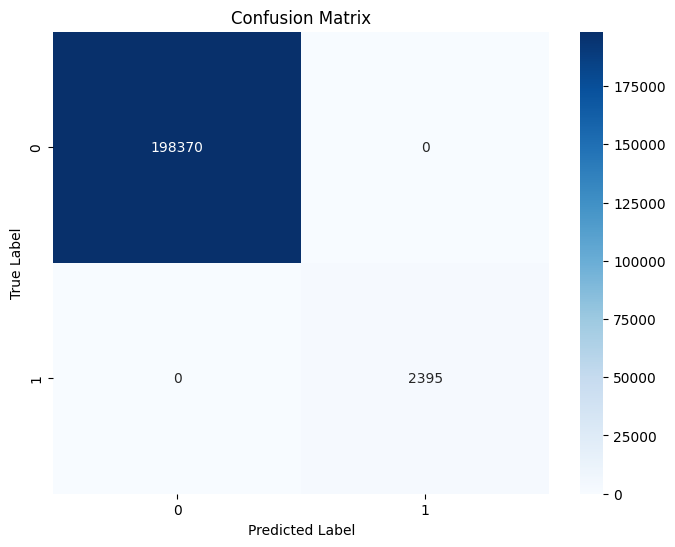

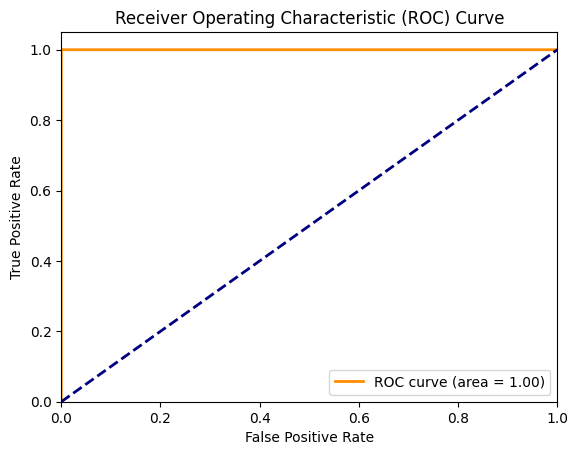

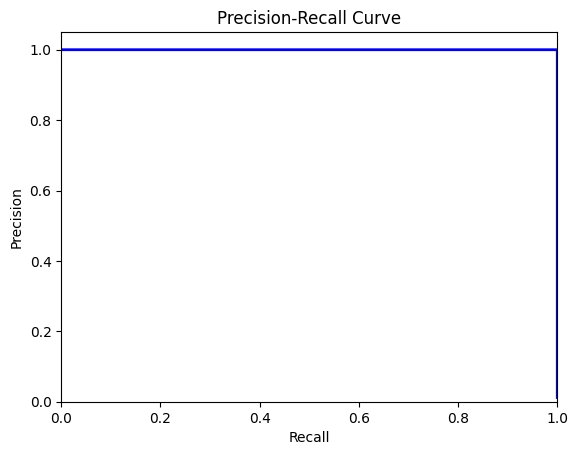

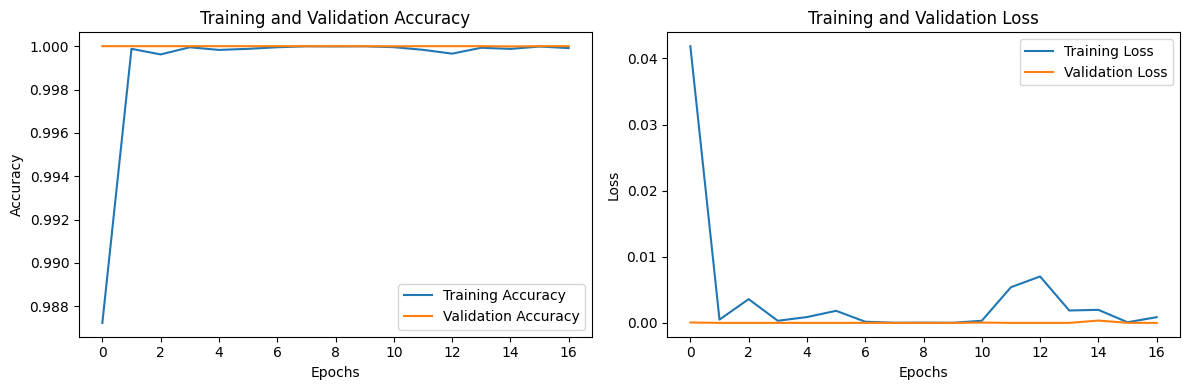

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import numpy as np
import seaborn as sns

# Assuming you have already trained your model and have the test data ready

# Generate predictions
y_pred_prob = model.predict(X_test_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()